In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action="ignore") #경고 표시 제거는 일시적으로만 하자... 중요한 내용일수도

import matplotlib.font_manager as fm #한글 안깨지게
font_name=fm.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name()
plt.rc("font", family=font_name)

import matplotlib as mpl # - 표시 정상적으로 되도록
mpl.rcParams["axes.unicode_minus"]=False

import urllib.request as req
from urllib.request import urlopen
from urllib.error import HTTPError, URLError
import urllib.parse
from urllib.parse import quote
from bs4 import BeautifulSoup
import requests

#=========================================================

from sklearn.model_selection import train_test_split

1. 교통사고 데이터에서 경기도 제외시키기 
2. 년도 줄이기 (2019? 2018-2019?)
3. 강우량 데이터에서 현충원 -> 동작구, 북악산 -> 종로구로 바꾸기
4. 교통사고, 강우량 데이터 합쳐서 구별, 일별로 강수량, 교통사고수, 사망자수 묶기 


## A. 교통사고 데이터

### 0. 데이터 불러오기

In [2]:
accident=pd.read_excel("data/미니프로젝트/2014_19년 서울_경기 개별 교통사고 정보.xlsx")

In [7]:
accident.info()
accident.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550791 entries, 0 to 550790
Data columns (total 26 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   발생일        550791 non-null  int64 
 1   발생시간       550791 non-null  object
 2   사망자수       550791 non-null  int64 
 3   중상자수       550791 non-null  int64 
 4   경상자수       550791 non-null  int64 
 5   부상신고자수     550791 non-null  int64 
 6   발생지_시도     550791 non-null  object
 7   발생지_시군구    550791 non-null  object
 8   법정동명       550773 non-null  object
 9   사고유형_대분류   550791 non-null  object
 10  사고유형_중분류   550791 non-null  object
 11  사고유형       550791 non-null  object
 12  가해자법규위반    550791 non-null  object
 13  도로형태_대분류   550791 non-null  object
 14  도로형태       550791 non-null  object
 15  노면상태_대분류   550791 non-null  object
 16  노면상태       550791 non-null  object
 17  기상상태       550791 non-null  object
 18  가해당사자종별    550791 non-null  object
 19  가해자성별      550791 non-null  object
 20  가해자연

,발생일,발생시간,사망자수,중상자수,경상자수,부상신고자수,발생지_시도,발생지_시군구,법정동명,사고유형_대분류,...,노면상태,기상상태,가해당사자종별,가해자성별,가해자연령,가해자신체상해정도,피해당사자종별,피해자성별,피해자연령,피해자신체상해정도
0,20140101,00시,0,0,1,0,서울,종로구,숭인동,차대차,...,젖음/습기,흐림,승합차,남,48세,기타불명,승용차,남,65세,상해없음
1,20140101,00시,0,0,1,0,서울,강북구,번동,차대사람,...,건조,맑음,불명,기타불명,불명,기타불명,보행자,남,60세,경상
2,20140101,00시,0,1,0,0,서울,강동구,천호동,차대사람,...,건조,맑음,승용차,남,38세,상해없음,보행자,남,59세,중상
3,20140101,00시,0,0,2,0,서울,구로구,궁동,차대차,...,건조,맑음,승용차,남,25세,상해없음,승용차,남,41세,경상
4,20140101,00시,0,0,0,2,서울,구로구,오류동,차대차,...,건조,맑음,승용차,남,31세,상해없음,승용차,남,65세,부상신고


In [8]:
#필요없는 열 삭제
accident.drop(["가해자법규위반","도로형태_대분류","노면상태_대분류","노면상태","기상상태","가해당사자종별","가해자성별","가해자연령","가해자신체상해정도","피해당사자종별","피해자성별","피해자연령","피해자신체상해정도","사고유형_대분류","사고유형_중분류"], axis=1, inplace=True)

In [9]:
accident.head()

,발생일,발생시간,사망자수,중상자수,경상자수,부상신고자수,발생지_시도,발생지_시군구,법정동명,사고유형,도로형태
0,20140101,00시,0,0,1,0,서울,종로구,숭인동,측면충돌,기타단일로
1,20140101,00시,0,0,1,0,서울,강북구,번동,횡단중,기타단일로
2,20140101,00시,0,1,0,0,서울,강동구,천호동,횡단중,교차로부근
3,20140101,00시,0,0,2,0,서울,구로구,궁동,진행중 추돌,교차로부근
4,20140101,00시,0,0,0,2,서울,구로구,오류동,기타,기타단일로


### 1. 날짜 범위 수정(2018~2019)

In [14]:
#날짜는 2018년부터
accident[accident["발생일"]>=20180101] #363827번부터 2018년 데이터 시작
accident.drop(range(0, 363827), axis=0, inplace=True)
accident.head()

,발생일,발생시간,사망자수,중상자수,경상자수,부상신고자수,발생지_시도,발생지_시군구,법정동명,사고유형,도로형태
363827,20180101,00시,0,0,2,0,서울,용산구,이태원동,측면충돌,교차로내
363828,20180101,00시,0,1,1,0,서울,강동구,강일동,측면충돌,교차로내
363829,20180101,00시,0,0,1,0,서울,송파구,방이동,차도통행중,교차로내
363830,20180101,00시,0,1,0,0,서울,성북구,하월곡동,횡단중,교차로횡단보도내
363831,20180101,00시,0,1,3,0,경기,안양시,관양동,측면충돌,교차로내


In [15]:
# 중간 세이브
accident.to_csv("data/미니프로젝트/2018-2019 교통사고 중간저장1.csv", sep=",")

In [7]:
# 다시 불러오기
accident=pd.read_csv("data/미니프로젝트/2018-2019 교통사고 중간저장1.csv")

In [8]:
accident.drop(["Unnamed: 0"], axis=1, inplace=True)
accident.head()

,발생일,발생시간,사망자수,중상자수,경상자수,부상신고자수,발생지_시도,발생지_시군구,법정동명,사고유형,도로형태
0,20180101,00시,0,0,2,0,서울,용산구,이태원동,측면충돌,교차로내
1,20180101,00시,0,1,1,0,서울,강동구,강일동,측면충돌,교차로내
2,20180101,00시,0,0,1,0,서울,송파구,방이동,차도통행중,교차로내
3,20180101,00시,0,1,0,0,서울,성북구,하월곡동,횡단중,교차로횡단보도내
4,20180101,00시,0,1,3,0,경기,안양시,관양동,측면충돌,교차로내


### 2. 경기도 교통사고 데이터 제외

In [9]:
accident = accident[accident["발생지_시도"]!="경기"]
accident["발생지_시도"].unique()

array(['서울'], dtype=object)

In [10]:
#필요없는 열 삭제 2
accident.drop(["도로형태", "사고유형", "발생시간", "법정동명"], axis=1, inplace=True)
accident.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78053 entries, 0 to 186960
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   발생일      78053 non-null  int64 
 1   사망자수     78053 non-null  int64 
 2   중상자수     78053 non-null  int64 
 3   경상자수     78053 non-null  int64 
 4   부상신고자수   78053 non-null  int64 
 5   발생지_시도   78053 non-null  object
 6   발생지_시군구  78053 non-null  object
dtypes: int64(5), object(2)
memory usage: 4.8+ MB


In [34]:
# 결측치 확인
accident.isnull().sum() # 법정동명에 한개 있음
accident[accident["법정동명"].isnull()] #어차피 별 의미는 없는듯

,발생일,사망자수,중상자수,경상자수,발생지_시도,발생지_시군구,법정동명
186332,20191229,0,0,1,서울,양천구,NaN


In [11]:
# 구 이름 확인 (나중에 합치기 위해)
accident["발생지_시군구"].unique()
len(accident["발생지_시군구"].unique())

25

In [12]:
# 중간 세이브 2
accident.to_csv("data/미니프로젝트/2018-2019 교통사고 중간저장4.csv", sep=",")

### 3. 일별/구별 데이터로 묶기 + merge 준비

In [13]:
accident=pd.read_csv("data/미니프로젝트/2018-2019 교통사고 중간저장4.csv", index_col=0)
accident.head()

,발생일,사망자수,중상자수,경상자수,부상신고자수,발생지_시도,발생지_시군구
0,20180101,0,0,2,0,서울,용산구
1,20180101,0,1,1,0,서울,강동구
2,20180101,0,0,1,0,서울,송파구
3,20180101,0,1,0,0,서울,성북구
8,20180101,0,0,1,0,서울,강북구


In [14]:
#groupby로 묶었을 때 사고 횟수도 볼 수 있도록, 모든 행에 1의 값을 지니는 "건수" 열 추가
accident["건수"]=1
accident.head()

,발생일,사망자수,중상자수,경상자수,부상신고자수,발생지_시도,발생지_시군구,건수
0,20180101,0,0,2,0,서울,용산구,1
1,20180101,0,1,1,0,서울,강동구,1
2,20180101,0,0,1,0,서울,송파구,1
3,20180101,0,1,0,0,서울,성북구,1
8,20180101,0,0,1,0,서울,강북구,1


In [15]:
#발생지_시군구를 "구별"로 변경
#발생일을 "날짜"로 변경
accident.rename(columns={"발생지_시군구":"구별"}, inplace=True)
accident.rename(columns={"발생일":"날짜"}, inplace=True)
accident.head()

,날짜,사망자수,중상자수,경상자수,부상신고자수,발생지_시도,구별,건수
0,20180101,0,0,2,0,서울,용산구,1
1,20180101,0,1,1,0,서울,강동구,1
2,20180101,0,0,1,0,서울,송파구,1
3,20180101,0,1,0,0,서울,성북구,1
8,20180101,0,0,1,0,서울,강북구,1


In [16]:
#accident.info() #날짜가 int 형식임 --> str --> 날짜로 바꾸기
accident["날짜"]=accident["날짜"].astype(str)
accident["날짜"]=pd.to_datetime(accident["날짜"]) #--> groupby로 묶으면 날짜 데이터로 바꾼 것 없어짐
accident.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78053 entries, 0 to 186960
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   날짜      78053 non-null  datetime64[ns]
 1   사망자수    78053 non-null  int64         
 2   중상자수    78053 non-null  int64         
 3   경상자수    78053 non-null  int64         
 4   부상신고자수  78053 non-null  int64         
 5   발생지_시도  78053 non-null  object        
 6   구별      78053 non-null  object        
 7   건수      78053 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 5.4+ MB


In [17]:
group_accident=accident.groupby(by=["구별","날짜"]).sum() #--> groupby로 묶으면 날짜 데이터로 바꾼 것 없어짐
group_accident.head()

사망자수  중상자수  경상자수  부상신고자수  건수
구별  날짜                                      
강남구 2018-01-01     0     1     2       2   4
    2018-01-02     0     2     3       0   5
    2018-01-03     0     4     8       1   9
    2018-01-04     0     3     6       1   8
    2018-01-05     0     5    12       1  14

In [18]:
# 저장
accident.to_csv("data/미니프로젝트/2018-2019 교통사고 중간저장5.csv", sep=",")
group_accident.to_csv("data/미니프로젝트/2018-2019 교통사고 groupby2.csv", sep=",")

## B. 강우량 데이터

### 1. 2018-2019 데이터 합치기

In [57]:
#import csv

#path = 'C:\jupyter_notebook\에이콘강의\데이터분석\data\미니프로젝트'
#file = '2018년 서울 일별 강우량 데이터.csv'
#f = open(path+file,'rt')
#f=open("data/미니프로젝트/2018년 서울 일별 강우량 데이터.csv", "rt")
#reader = csv.reader(f)

#once contents are available, I then put them in a list
#csv_list = []
#for l in reader:
#    csv_list.append(l)
#f.close()
#now pandas has no problem getting into a df
#df = pd.DataFrame(csv_list)

### ParserError: Error tokenizing data로 인해 수동으로 csv파일 수정했음...

In [4]:
rain2018=pd.read_csv("data/미니프로젝트/2018년 서울 일별 강우량 데이터_수정.csv", encoding="euc-kr")
rain2018.info() #강수량/1시간최다강수량에서 결측치 있는듯

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10186 entries, 0 to 10185
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   	지점번호         10186 non-null  int64  
 1   지점명           10186 non-null  object 
 2   일시            10186 non-null  object 
 3   강수량(mm)       10181 non-null  float64
 4   1시간최다강수량(mm)  10183 non-null  float64
 5   1시간최다강수량시각    10186 non-null  object 
 6   Unnamed: 6    0 non-null      float64
dtypes: float64(3), int64(1), object(3)
memory usage: 557.2+ KB


In [18]:
jongro2018=pd.read_csv("data/미니프로젝트/2018년 종로구 일별 강수량.csv", encoding="euc-kr")
jongro2018.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   	지점번호         365 non-null    int64  
 1   지점명           365 non-null    object 
 2   일시            365 non-null    object 
 3   강수량(mm)       128 non-null    float64
 4   1시간최다강수량(mm)  85 non-null     float64
 5   1시간최다강수량시각    65 non-null     object 
 6   Unnamed: 6    0 non-null      float64
dtypes: float64(3), int64(1), object(3)
memory usage: 20.1+ KB


In [21]:
rain2018=pd.concat([rain2018,jongro2018])
rain2018["지점명"].unique()

array(['강남', '서초', '강동', '송파', '강서', '양천', '도봉', '노원', '동대문', '중랑', '기상청',
       '마포', '서대문', '광진', '성북', '용산', '은평', '금천', '한강', '중구', '성동', '북악산',
       '구로', '강북', '남현', '관악', '영등포 ', '현충원', '서울'], dtype=object)

In [5]:
rain2019=pd.read_csv("data/미니프로젝트/2019년 서울 일별 강우량 데이터_수정.csv", encoding="euc-kr")
rain2019.info() #강수량/1시간최다강수량/1시간최다강수량시각에서 결측치 있는듯

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9845 entries, 0 to 9844
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   	지점번호         9845 non-null   int64  
 1   지점명           9845 non-null   object 
 2   일시            9845 non-null   object 
 3   강수량(mm)       9828 non-null   float64
 4   1시간최다강수량(mm)  9830 non-null   float64
 5   1시간최다강수량시각    9844 non-null   object 
 6   Unnamed: 6    0 non-null      float64
dtypes: float64(3), int64(1), object(3)
memory usage: 538.5+ KB


In [20]:
jongro2019=pd.read_csv("data/미니프로젝트/2019년 종로구 일별 강수량.csv", encoding="euc-kr")
jongro2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   	지점번호         365 non-null    int64  
 1   지점명           365 non-null    object 
 2   일시            365 non-null    object 
 3   강수량(mm)       139 non-null    float64
 4   1시간최다강수량(mm)  88 non-null     float64
 5   1시간최다강수량시각    58 non-null     object 
 6   Unnamed: 6    0 non-null      float64
dtypes: float64(3), int64(1), object(3)
memory usage: 20.1+ KB


In [22]:
rain2019=pd.concat([rain2019,jongro2019])

In [31]:
rain2018["지점명"].unique()

array(['강남', '서초', '강동', '송파', '강서', '양천', '도봉', '노원', '동대문', '중랑', '기상청',
       '마포', '서대문', '광진', '성북', '용산', '은평', '금천', '한강', '중구', '성동', '북악산',
       '구로', '강북', '남현', '관악', '영등포 ', '현충원', '서울'], dtype=object)

In [32]:
rain2019["지점명"].unique()

array(['강남', '서초', '강동', '송파', '강서', '양천', '도봉', '노원', '동대문', '중랑', '기상청',
       '마포', '서대문', '광진', '성북', '용산', '은평', '금천', '한강', '중구', '성동', '구로',
       '강북', '남현', '관악', '영등포 ', '현충원', '서울'], dtype=object)

In [25]:
#필요없는 열 제거
rain2018.drop(["1시간최다강수량시각", "Unnamed: 6"], axis=1, inplace=True)
rain2019.drop(["1시간최다강수량시각", "Unnamed: 6"], axis=1, inplace=True)

In [27]:
#결측치 확인/제거
rain2018.isnull().sum() 
rain2018[rain2018["강수량(mm)"].isnull()]
rain2018.fillna(0, inplace=True) #0으로 대체
rain2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10551 entries, 0 to 364
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   	지점번호         10551 non-null  int64  
 1   지점명           10551 non-null  object 
 2   일시            10551 non-null  object 
 3   강수량(mm)       10551 non-null  float64
 4   1시간최다강수량(mm)  10551 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 494.6+ KB


In [28]:
#결측치 확인/제거
rain2019.isnull().sum()
rain2019.fillna(0, inplace=True) #0으로 대체
rain2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10210 entries, 0 to 364
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   	지점번호         10210 non-null  int64  
 1   지점명           10210 non-null  object 
 2   일시            10210 non-null  object 
 3   강수량(mm)       10210 non-null  float64
 4   1시간최다강수량(mm)  10210 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 478.6+ KB


In [33]:
# 두 파일이 형식 면에서 동일하니, concat으로 그대로 합치면 될 듯.
rain2018.head()
rain2019.head()

rain=pd.concat([rain2018, rain2019]) #행 기준으로(위아래로) 합침
rain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20761 entries, 0 to 364
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   	지점번호         20761 non-null  int64  
 1   지점명           20761 non-null  object 
 2   일시            20761 non-null  object 
 3   강수량(mm)       20761 non-null  float64
 4   1시간최다강수량(mm)  20761 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 973.2+ KB


In [34]:
#중간저장

rain.to_csv("data/미니프로젝트/2018-2019 강수량 데이터 중간저장7.csv", sep=",")

### 2. 지점 이름 구에 맞춰서 바꾸기

In [35]:
rain=pd.read_csv("data/미니프로젝트/2018-2019 강수량 데이터 중간저장7.csv", index_col=0)

In [6]:
rain.groupby(by="지점명").sum()

NameError: name 'rain' is not defined

In [37]:
rain["지점명"].unique()
#len(rain["지점명"].unique())
# --> 현충원/기상청 = 동작, 북악산 = 종로, 한강=영등포, 남현=관악으로 변경
# --> 서울 외 지역인 북한산 제거

array(['강남', '서초', '강동', '송파', '강서', '양천', '도봉', '노원', '동대문', '중랑', '기상청',
       '마포', '서대문', '광진', '성북', '용산', '은평', '금천', '한강', '중구', '성동', '북악산',
       '구로', '강북', '남현', '관악', '영등포 ', '현충원', '서울'], dtype=object)

In [45]:
def guname(x):
    if x=="현충원":
        return "동작"
    elif x=="기상청":
        return "동작"
    elif x=="서울":
        return "종로"
    elif x=="한강":
        return "영등포"
    elif x=="남현":
        return "관악"
    elif x=="영등포 ":
        return "영등포"
    else:
        return x

In [46]:
rain["지점명"]=rain["지점명"].apply(guname)
# 현충원 --> 동작, 북악산 --> 종로로 변경

In [41]:
#a1=rain[rain["지점명"]=="한강"].index
#a2=rain[rain["지점명"]=="기상청"].index
#a3=rain[rain["지점명"]=="남현"].index

#a=list(a1)+list(a2)+list(a3)
#지점명이 한강, 기상청, 남현인 행들의 번호를 모아서 drop에 적용
#rain.drop(a, axis=0)
#rain.drop(a, axis=0)["지점명"].unique()

a=rain[rain["지점명"]=="북악산"].index

rain.drop(a, axis=0, inplace=True)

In [52]:
rain["지점명"].unique()

array(['강남', '서초', '강동', '송파', '강서', '양천', '도봉', '노원', '동대문', '중랑', '동작',
       '마포', '서대문', '광진', '성북', '용산', '은평', '금천', '영등포', '중구', '성동', '구로',
       '강북', '관악', '종로'], dtype=object)

In [31]:
#불러오면서 추가된 unnamed행 제거 --> 파일 불러올 때 index_col=0 지정시 할 필요 없음
#rain.drop("Unnamed: 0", axis=1, inplace=True)
rain.head()

,\t지점번호,지점명,일시,강수량(mm),1시간최다강수량(mm)
0,400,강남,2018-01-01,0.0,0.0
1,400,강남,2018-01-02,0.0,0.0
2,400,강남,2018-01-03,0.0,0.0
3,400,강남,2018-01-04,0.0,0.0
4,400,강남,2018-01-05,0.0,0.0


In [53]:
# 중간 저장
rain.to_csv("data/미니프로젝트/2018-2019 강수량 데이터 중간저장8.csv", sep=",")

### 3. 일별/구별로 묶기 + merge 준비

In [54]:
rain=pd.read_csv("data/미니프로젝트/2018-2019 강수량 데이터 중간저장8.csv", index_col=0)

In [55]:
#지점명를 "구별"로 변경
#일시를 "날짜"로 변경
rain.rename(columns={"지점명":"구별"}, inplace=True)
rain.rename(columns={"일시":"날짜"}, inplace=True)
rain.head()

,\t지점번호,구별,날짜,강수량(mm),1시간최다강수량(mm)
0,400,강남,2018-01-01,0.0,0.0
1,400,강남,2018-01-02,0.0,0.0
2,400,강남,2018-01-03,0.0,0.0
3,400,강남,2018-01-04,0.0,0.0
4,400,강남,2018-01-05,0.0,0.0


In [56]:
#구별을 ...구로 변경
def gu(x):
    return x+"구"

rain["구별"]=rain["구별"].apply(gu)

In [57]:
#rain["구별"].unique() #중구/영등포구 수정 필요

def gu2(x):
    if x=="중구구":
        return "중구"
    elif x=="영등포 구":
        return "영등포구"
    else:
        return x
    
rain["구별"]=rain["구별"].apply(gu2)

In [58]:
rain["구별"].unique() #수정 완료

array(['강남구', '서초구', '강동구', '송파구', '강서구', '양천구', '도봉구', '노원구', '동대문구',
       '중랑구', '동작구', '마포구', '서대문구', '광진구', '성북구', '용산구', '은평구', '금천구',
       '영등포구', '중구', '성동구', '구로구', '강북구', '관악구', '종로구'], dtype=object)

In [68]:
#rain.info()
#날짜를 날짜 데이터로 변환
rain["날짜"]=pd.to_datetime(rain["날짜"])
rain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20089 entries, 0 to 364
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   	지점번호         20089 non-null  int64         
 1   구별            20089 non-null  object        
 2   날짜            20089 non-null  datetime64[ns]
 3   강수량(mm)       20089 non-null  float64       
 4   1시간최다강수량(mm)  20089 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 941.7+ KB


In [80]:
print(rain[rain["구별"]=="관악구"]["강수량(mm)"].sum())
print(rain[rain["구별"]=="동작구"]["강수량(mm)"].sum())
print(rain[rain["구별"]=="영등포구"]["강수량(mm)"].sum())

print(rain[rain["구별"]=="관악구"]["1시간최다강수량(mm)"].sum())
print(rain[rain["구별"]=="동작구"]["1시간최다강수량(mm)"].sum())
print(rain[rain["구별"]=="영등포구"]["1시간최다강수량(mm)"].sum())

#print(rain[rain["구별"]=="강남구"]["1시간최다강수량(mm)"].sum())
#print(rain[rain["구별"]=="서초구"]["1시간최다강수량(mm)"].sum())


4762.0
4379.0
4116.5
1779.5
1803.0
1836.5


In [69]:
# 일별/구별로 묶기
group_rain=rain.groupby(by=["구별","날짜"]).sum() #--> groupby로 묶으면 날짜 데이터로 바꾼 것 없어짐
group_rain.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 17902 entries, ('강남구', Timestamp('2018-01-01 00:00:00')) to ('중랑구', Timestamp('2019-12-31 00:00:00'))
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   	지점번호         17902 non-null  int64  
 1   강수량(mm)       17902 non-null  float64
 2   1시간최다강수량(mm)  17902 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 478.1+ KB


In [70]:
# 지점이 2개인 동작/영등포/관악구는 강수량 2로 나눠야 함 --> 지점번호로 나누기
aa = rain["\t지점번호"].unique()
for center in aa:
    print(center, rain[rain["\t지점번호"]==center]["구별"].unique())

# 지점번호 425+509가 관악/418+510이 영등포/410+889가 동작

400 ['강남구']
401 ['서초구']
402 ['강동구']
403 ['송파구']
404 ['강서구']
405 ['양천구']
406 ['도봉구']
407 ['노원구']
408 ['동대문구']
409 ['중랑구']
410 ['동작구']
411 ['마포구']
412 ['서대문구']
413 ['광진구']
414 ['성북구']
415 ['용산구']
416 ['은평구']
417 ['금천구']
418 ['영등포구']
419 ['중구']
421 ['성동구']
423 ['구로구']
424 ['강북구']
425 ['관악구']
509 ['관악구']
510 ['영등포구']
889 ['동작구']
108 ['종로구']


In [71]:
group_rain[group_rain["\t지점번호"]==934] #관악
group_rain[group_rain["\t지점번호"]==928] #영등포
group_rain[group_rain["\t지점번호"]==1299] # 동작

\t지점번호  강수량(mm)  1시간최다강수량(mm)
구별  날짜                                       
동작구 2018-01-01    1299      0.0           0.0
    2018-01-02    1299      0.0           0.0
    2018-01-03    1299      0.0           0.0
    2018-01-04    1299      0.0           0.0
    2018-01-05    1299      0.0           0.0
...                ...      ...           ...
    2019-12-27    1299      0.0           0.0
    2019-12-28    1299      0.0           0.0
    2019-12-29    1299      3.0           2.0
    2019-12-30    1299      0.0           0.0
    2019-12-31    1299      0.0           0.0

[730 rows x 3 columns]

In [72]:
group_rain["강수량"]=group_rain["강수량(mm)"]
group_rain["1시간최다강수량"]=group_rain["1시간최다강수량(mm)"]
group_rain

\t지점번호  강수량(mm)  1시간최다강수량(mm)  강수량  1시간최다강수량
구별  날짜                                                      
강남구 2018-01-01     400      0.0           0.0  0.0       0.0
    2018-01-02     400      0.0           0.0  0.0       0.0
    2018-01-03     400      0.0           0.0  0.0       0.0
    2018-01-04     400      0.0           0.0  0.0       0.0
    2018-01-05     400      0.0           0.0  0.0       0.0
...                ...      ...           ...  ...       ...
중랑구 2019-12-27     409      0.0           0.0  0.0       0.0
    2019-12-28     409      0.0           0.0  0.0       0.0
    2019-12-29     409      1.5           1.0  1.5       1.0
    2019-12-30     409      0.0           0.0  0.0       0.0
    2019-12-31     409      0.0           0.0  0.0       0.0

[17902 rows x 5 columns]

In [73]:
group_rain.loc[group_rain["\t지점번호"]==934, "강수량"] = group_rain["강수량"]/2
group_rain.loc[group_rain["\t지점번호"]==928, "강수량"] = group_rain["강수량"]/2
group_rain.loc[group_rain["\t지점번호"]==1299, "강수량"] = group_rain["강수량"]/2

print(group_rain[group_rain["\t지점번호"]==934]["강수량"].sum())
print(group_rain[group_rain["\t지점번호"]==928]["강수량"].sum())
print(group_rain[group_rain["\t지점번호"]==1299]["강수량"].sum())

2381.0
2058.25
2189.5


In [74]:
group_rain.loc[group_rain["\t지점번호"]==934, "1시간최다강수량"] = group_rain["1시간최다강수량"]/2
group_rain.loc[group_rain["\t지점번호"]==928, "1시간최다강수량"] = group_rain["1시간최다강수량"]/2
group_rain.loc[group_rain["\t지점번호"]==1299, "1시간최다강수량"] = group_rain["1시간최다강수량"]/2

print(group_rain[group_rain["\t지점번호"]==934]["1시간최다강수량"].sum())
print(group_rain[group_rain["\t지점번호"]==928]["1시간최다강수량"].sum())
print(group_rain[group_rain["\t지점번호"]==1299]["1시간최다강수량"].sum())

889.75
918.25
901.5


In [75]:
group_rain["1시간최다강수량"].sum()

22284.4

In [76]:
group_rain2=group_rain.drop(["\t지점번호", "강수량(mm)", "1시간최다강수량(mm)"], axis=1)
group_rain2

강수량  1시간최다강수량
구별  날짜                       
강남구 2018-01-01  0.0       0.0
    2018-01-02  0.0       0.0
    2018-01-03  0.0       0.0
    2018-01-04  0.0       0.0
    2018-01-05  0.0       0.0
...             ...       ...
중랑구 2019-12-27  0.0       0.0
    2019-12-28  0.0       0.0
    2019-12-29  1.5       1.0
    2019-12-30  0.0       0.0
    2019-12-31  0.0       0.0

[17902 rows x 2 columns]

In [77]:
# 저장
rain.to_csv("data/미니프로젝트/2018-2019 강수량 데이터 중간저장9.csv", sep=",")
group_rain2.to_csv("data/미니프로젝트/2018-2019 강수량 데이터 groupby3.csv", sep=",")

## C. 파일 합치기

In [83]:
group_accident=pd.read_csv('data/미니프로젝트/2018-2019 교통사고 groupby2.csv')
group_rain=pd.read_csv('data/미니프로젝트/2018-2019 강수량 데이터 groupby3.csv')

In [84]:
# 무의미한 열 빼기 3
#group_rain.drop("\t지점번호", axis=1, inplace=True)
group_rain.head()

,구별,날짜,강수량,1시간최다강수량
0,강남구,2018-01-01,0.0,0.0
1,강남구,2018-01-02,0.0,0.0
2,강남구,2018-01-03,0.0,0.0
3,강남구,2018-01-04,0.0,0.0
4,강남구,2018-01-05,0.0,0.0


In [85]:
#groupby로 묶으면서 날짜 다시 obj로 바뀜 --> 날짜로 바꿔주기
#group_rain.info()
group_rain["날짜"]=pd.to_datetime(group_rain["날짜"])
group_rain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17902 entries, 0 to 17901
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   구별        17902 non-null  object        
 1   날짜        17902 non-null  datetime64[ns]
 2   강수량       17902 non-null  float64       
 3   1시간최다강수량  17902 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 559.6+ KB


In [86]:
#groupby로 묶으면서 날짜 다시 obj로 바뀜 --> 날짜로 바꿔주기
#group_accident.info()
group_accident["날짜"]=pd.to_datetime(group_accident["날짜"])
group_accident.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17599 entries, 0 to 17598
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   구별      17599 non-null  object        
 1   날짜      17599 non-null  datetime64[ns]
 2   사망자수    17599 non-null  int64         
 3   중상자수    17599 non-null  int64         
 4   경상자수    17599 non-null  int64         
 5   부상신고자수  17599 non-null  int64         
 6   건수      17599 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 962.6+ KB


In [87]:
#합치기
rain_accident=pd.merge(group_rain, group_accident, how="outer", on=["구별","날짜"])
rain_accident.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18241 entries, 0 to 18240
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   구별        18241 non-null  object        
 1   날짜        18241 non-null  datetime64[ns]
 2   강수량       17902 non-null  float64       
 3   1시간최다강수량  17902 non-null  float64       
 4   사망자수      17599 non-null  float64       
 5   중상자수      17599 non-null  float64       
 6   경상자수      17599 non-null  float64       
 7   부상신고자수    17599 non-null  float64       
 8   건수        17599 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 1.4+ MB


In [88]:
#결측치 확인
#강수량/교통사고 관련 데이터 모두 0으로 채우면 될듯
rain_accident.isnull().sum()

구별            0
날짜            0
강수량         339
1시간최다강수량    339
사망자수        642
중상자수        642
경상자수        642
부상신고자수      642
건수          642
dtype: int64

In [350]:
#rain_accident[rain_accident["강수량(mm)"].isnull()]

,구별,날짜,강수량(mm),사망자수,중상자수,경상자수,건수
17844,강남구,2018-04-15,NaN,0.0,2.0,3.0,5.0
17845,금천구,2019-01-05,NaN,0.0,0.0,5.0,4.0
17846,용산구,2018-12-30,NaN,0.0,3.0,5.0,3.0
17847,용산구,2019-09-21,NaN,0.0,1.0,2.0,3.0
17848,용산구,2019-09-22,NaN,0.0,2.0,6.0,5.0
...,...,...,...,...,...,...,...
18225,중구,2019-11-03,NaN,0.0,2.0,6.0,5.0
18226,중랑구,2019-04-25,NaN,0.0,2.0,5.0,6.0
18227,중랑구,2019-04-26,NaN,0.0,0.0,4.0,4.0
18228,중랑구,2019-04-27,NaN,0.0,0.0,9.0,7.0


In [355]:
#group_rain[group_rain["날짜"]=="2018-04-15"]

,구별,날짜,강수량(mm)
833,강동구,2018-04-15,0.0
1563,강북구,2018-04-15,0.0
2293,강서구,2018-04-15,0.0
3023,관악구,2018-04-15,0.0
3753,광진구,2018-04-15,0.0
4483,구로구,2018-04-15,0.0
5213,금천구,2018-04-15,0.0
5941,노원구,2018-04-15,0.0
6671,도봉구,2018-04-15,0.0
7401,동대문구,2018-04-15,0.0


In [89]:
#강수량/교통사고 관련 데이터 모두 0으로 채우면 될듯
rain_accident=rain_accident.fillna(0)
rain_accident.isnull().sum()
rain_accident.info()

#구 갯수 25 * 날짜 갯수 730 하면 18250 나와야 하는데 9일은 강수량 데이터/교통사고 데이터 모두 없는 날이라고 보면 될 듯

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18241 entries, 0 to 18240
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   구별        18241 non-null  object        
 1   날짜        18241 non-null  datetime64[ns]
 2   강수량       18241 non-null  float64       
 3   1시간최다강수량  18241 non-null  float64       
 4   사망자수      18241 non-null  float64       
 5   중상자수      18241 non-null  float64       
 6   경상자수      18241 non-null  float64       
 7   부상신고자수    18241 non-null  float64       
 8   건수        18241 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 1.4+ MB


In [4]:
#저장하기
rain_accident.to_csv("data/미니프로젝트/강수량-교통사고 데이터 통합3.csv", sep=",")

NameError: name 'rain_accident' is not defined

In [5]:
rain_accident=pd.read_csv("data/미니프로젝트/강수량-교통사고 데이터 통합3.csv", index_col=0)

In [6]:
rain_accident

,구별,날짜,강수량,1시간최다강수량,사망자수,중상자수,경상자수,부상신고자수,건수
0,강남구,2018-01-01,0.0,0.0,0.0,1.0,2.0,2.0,4.0
1,강남구,2018-01-02,0.0,0.0,0.0,2.0,3.0,0.0,5.0
2,강남구,2018-01-03,0.0,0.0,0.0,4.0,8.0,1.0,9.0
3,강남구,2018-01-04,0.0,0.0,0.0,3.0,6.0,1.0,8.0
4,강남구,2018-01-05,0.0,0.0,0.0,5.0,12.0,1.0,14.0
...,...,...,...,...,...,...,...,...,...
18236,중구,2019-11-03,0.0,0.0,0.0,2.0,6.0,0.0,5.0
18237,중랑구,2019-04-25,0.0,0.0,0.0,2.0,5.0,0.0,6.0
18238,중랑구,2019-04-26,0.0,0.0,0.0,0.0,4.0,2.0,4.0
18239,중랑구,2019-04-27,0.0,0.0,0.0,0.0,9.0,1.0,7.0


In [7]:
rain_accident.columns
rain_accident.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18241 entries, 0 to 18240
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   구별        18241 non-null  object 
 1   날짜        18241 non-null  object 
 2   강수량       18241 non-null  float64
 3   1시간최다강수량  18241 non-null  float64
 4   사망자수      18241 non-null  float64
 5   중상자수      18241 non-null  float64
 6   경상자수      18241 non-null  float64
 7   부상신고자수    18241 non-null  float64
 8   건수        18241 non-null  float64
dtypes: float64(7), object(2)
memory usage: 1.4+ MB


In [8]:
data_to_insert1 = {'구별': '구로구', '날짜': '2019-01-23'}
data_to_insert2 = {'구별': '구로구', '날짜': '2019-05-19'}
data_to_insert3 = {'구별': '구로구', '날짜': '2019-07-01'}
data_to_insert4 = {'구별': '구로구', '날짜': '2019-07-27'}
data_to_insert5 = {'구별': '구로구', '날짜': '2019-08-25'}
data_to_insert6 = {'구별': '구로구', '날짜': '2019-09-07'}
data_to_insert7 = {'구별': '구로구', '날짜': '2019-09-14'}
data_to_insert8 = {'구별': '구로구', '날짜': '2019-10-31'}
data_to_insert9 = {'구별': '금천구', '날짜': '2019-01-06'}


In [9]:
rain_accident=rain_accident.append(data_to_insert1, ignore_index=True)
rain_accident=rain_accident.append(data_to_insert2, ignore_index=True)
rain_accident=rain_accident.append(data_to_insert3, ignore_index=True)
rain_accident=rain_accident.append(data_to_insert4, ignore_index=True)
rain_accident=rain_accident.append(data_to_insert5, ignore_index=True)
rain_accident=rain_accident.append(data_to_insert6, ignore_index=True)
rain_accident=rain_accident.append(data_to_insert7, ignore_index=True)
rain_accident=rain_accident.append(data_to_insert8, ignore_index=True)
rain_accident=rain_accident.append(data_to_insert9, ignore_index=True)

rain_accident.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18250 entries, 0 to 18249
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   구별        18250 non-null  object 
 1   날짜        18250 non-null  object 
 2   강수량       18241 non-null  float64
 3   1시간최다강수량  18241 non-null  float64
 4   사망자수      18241 non-null  float64
 5   중상자수      18241 non-null  float64
 6   경상자수      18241 non-null  float64
 7   부상신고자수    18241 non-null  float64
 8   건수        18241 non-null  float64
dtypes: float64(7), object(2)
memory usage: 1.3+ MB


In [10]:
rain_accident=rain_accident.fillna(0)
rain_accident.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18250 entries, 0 to 18249
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   구별        18250 non-null  object 
 1   날짜        18250 non-null  object 
 2   강수량       18250 non-null  float64
 3   1시간최다강수량  18250 non-null  float64
 4   사망자수      18250 non-null  float64
 5   중상자수      18250 non-null  float64
 6   경상자수      18250 non-null  float64
 7   부상신고자수    18250 non-null  float64
 8   건수        18250 non-null  float64
dtypes: float64(7), object(2)
memory usage: 1.3+ MB


In [11]:
for gu in rain_accident["구별"].unique():
    print(len(rain_accident[rain_accident["구별"]==gu]))

730
730
730
730
730
730
730
730
730
730
730
730
730
730
730
730
730
730
730
730
730
730
730
730
730


In [12]:
#중간 저장
rain_accident.to_csv("data/미니프로젝트/강수량-교통사고 데이터 통합4.csv", sep=",")

In [14]:
#다시 불러오기
rain_accident=pd.read_csv("data/미니프로젝트/강수량-교통사고 데이터 통합4.csv", index_col=0)

In [15]:
rain_accident

,구별,날짜,강수량,1시간최다강수량,사망자수,중상자수,경상자수,부상신고자수,건수
0,강남구,2018-01-01,0.0,0.0,0.0,1.0,2.0,2.0,4.0
1,강남구,2018-01-02,0.0,0.0,0.0,2.0,3.0,0.0,5.0
2,강남구,2018-01-03,0.0,0.0,0.0,4.0,8.0,1.0,9.0
3,강남구,2018-01-04,0.0,0.0,0.0,3.0,6.0,1.0,8.0
4,강남구,2018-01-05,0.0,0.0,0.0,5.0,12.0,1.0,14.0
...,...,...,...,...,...,...,...,...,...
18245,구로구,2019-08-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18246,구로구,2019-09-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18247,구로구,2019-09-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18248,구로구,2019-10-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:xlabel='강수량'>

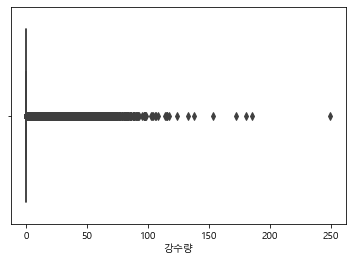

In [18]:
sns.boxplot(rain_accident["강수량"])

<AxesSubplot:xlabel='사망자수'>

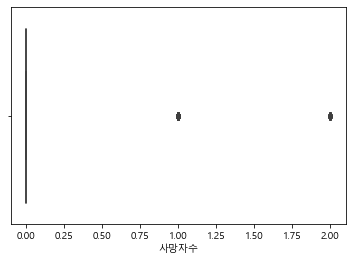

In [19]:
sns.boxplot(rain_accident["사망자수"])

<AxesSubplot:xlabel='건수'>

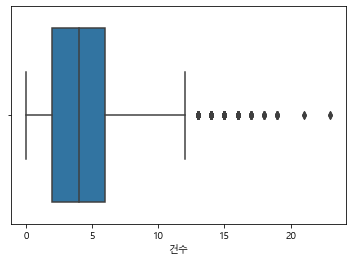

In [20]:
sns.boxplot(rain_accident["건수"])

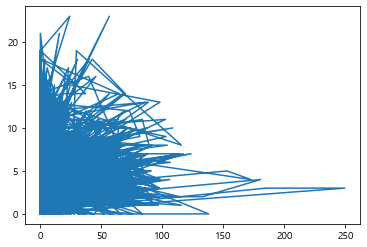

In [21]:
plt.plot(rain_accident["강수량"], rain_accident["건수"])

In [22]:
rain_accident.corr() #상관관계 없는듯;;

,강수량,1시간최다강수량,사망자수,중상자수,경상자수,부상신고자수,건수
강수량,1.000000,0.873193,0.002237,0.011271,0.030229,0.006209,0.032544
1시간최다강수량,0.873193,1.000000,0.007406,-0.002738,0.024723,0.000894,0.023361
사망자수,0.002237,0.007406,1.000000,0.041818,0.042375,0.023809,0.102366
중상자수,0.011271,-0.002738,0.041818,1.000000,0.308059,0.141265,0.550165
경상자수,0.030229,0.024723,0.042375,0.308059,1.000000,0.249654,0.809566
부상신고자수,0.006209,0.000894,0.023809,0.141265,0.249654,1.000000,0.356688
건수,0.032544,0.023361,0.102366,0.550165,0.809566,0.356688,1.000000


In [25]:
rain_accident["강수여부"]=rain_accident["강수량"]

In [27]:
def rain(x):
    if x==0:
        return x
    else:
        return 1

rain_accident["강수여부"]=rain_accident["강수여부"].apply(rain)

In [29]:
rain_accident["강수여부"].unique()

array([0., 1.])

In [32]:
rain_accident.corr() #강수여부만 봐도 큰 관계 없는듯...

,강수량,1시간최다강수량,사망자수,중상자수,경상자수,부상신고자수,건수,강수여부
강수량,1.000000,0.873193,0.002237,0.011271,0.030229,0.006209,0.032544,0.503160
1시간최다강수량,0.873193,1.000000,0.007406,-0.002738,0.024723,0.000894,0.023361,0.521511
사망자수,0.002237,0.007406,1.000000,0.041818,0.042375,0.023809,0.102366,0.013414
중상자수,0.011271,-0.002738,0.041818,1.000000,0.308059,0.141265,0.550165,-0.000419
경상자수,0.030229,0.024723,0.042375,0.308059,1.000000,0.249654,0.809566,0.017178
부상신고자수,0.006209,0.000894,0.023809,0.141265,0.249654,1.000000,0.356688,0.003576
건수,0.032544,0.023361,0.102366,0.550165,0.809566,0.356688,1.000000,0.022151
강수여부,0.503160,0.521511,0.013414,-0.000419,0.017178,0.003576,0.022151,1.000000


In [33]:
rain_accident["폭우여부1"]=rain_accident["강수량"]
rain_accident["폭우여부2"]=rain_accident["1시간최다강수량"]

In [35]:
def dailypoku(x):
    if x>=80:
        return 1
    else:
        return 0

def hourlypoku(x):
    if x>=30:
        return 1
    else:
        return 0

In [36]:
rain_accident["폭우여부1"]=rain_accident["폭우여부1"].apply(dailypoku)
rain_accident["폭우여부2"]=rain_accident["폭우여부2"].apply(hourlypoku)

In [39]:
rain_accident["폭우여부종합"]=rain_accident["폭우여부1"]+rain_accident["폭우여부2"]

In [42]:
rain_accident.corr()

,강수량,1시간최다강수량,사망자수,중상자수,경상자수,부상신고자수,건수,강수여부,폭우여부1,폭우여부2,폭우여부종합
강수량,1.000000,0.873193,0.002237,0.011271,0.030229,0.006209,0.032544,0.503160,0.572813,0.459687,0.608941
1시간최다강수량,0.873193,1.000000,0.007406,-0.002738,0.024723,0.000894,0.023361,0.521511,0.462635,0.646192,0.661204
사망자수,0.002237,0.007406,1.000000,0.041818,0.042375,0.023809,0.102366,0.013414,-0.006651,-0.003667,-0.006041
중상자수,0.011271,-0.002738,0.041818,1.000000,0.308059,0.141265,0.550165,-0.000419,0.004846,-0.004310,0.000100
경상자수,0.030229,0.024723,0.042375,0.308059,1.000000,0.249654,0.809566,0.017178,0.017329,0.015233,0.019239
부상신고자수,0.006209,0.000894,0.023809,0.141265,0.249654,1.000000,0.356688,0.003576,0.004024,-0.006480,-0.001704
건수,0.032544,0.023361,0.102366,0.550165,0.809566,0.356688,1.000000,0.022151,0.013998,0.004313,0.010617
강수여부,0.503160,0.521511,0.013414,-0.000419,0.017178,0.003576,0.022151,1.000000,0.124286,0.134775,0.153711
폭우여부1,0.572813,0.462635,-0.006651,0.004846,0.017329,0.004024,0.013998,0.124286,1.000000,0.423940,0.829824
폭우여부2,0.459687,0.646192,-0.003667,-0.004310,0.015233,-0.006480,0.004313,0.134775,0.423940,1.000000,0.857194


In [43]:
rain_accident.to_csv("data/미니프로젝트/강수량-교통사고 데이터 통합5.csv", sep=",")

In [3]:
rain_accident=pd.read_csv("data/미니프로젝트/강수량-교통사고 데이터 통합5.csv", index_col=0)

In [5]:
rain_accident[rain_accident["강수여부"]==1].count()

구별          4048
날짜          4048
강수량         4048
1시간최다강수량    4048
사망자수        4048
중상자수        4048
경상자수        4048
부상신고자수      4048
건수          4048
강수여부        4048
폭우여부1       4048
폭우여부2       4048
폭우여부종합      4048
dtype: int64

In [3]:
rain=pd.read_csv("data/미니프로젝트/2018-2019 강수량 데이터 중간저장9.csv", index_col=0)

In [7]:
rain.drop("\t지점번호", axis=1, inplace=True)
rain

,구별,날짜,강수량(mm),1시간최다강수량(mm)
0,강남구,2018-01-01,0.0,0.0
1,강남구,2018-01-02,0.0,0.0
2,강남구,2018-01-03,0.0,0.0
3,강남구,2018-01-04,0.0,0.0
4,강남구,2018-01-05,0.0,0.0
...,...,...,...,...
360,종로구,2019-12-27,0.0,0.0
361,종로구,2019-12-28,0.0,0.0
362,종로구,2019-12-29,1.4,0.0
363,종로구,2019-12-30,0.4,0.0
